In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install resampy

import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten,  MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.0 MB/s eta 0:00:00


In [ ]:
import os
audio_files_path = "/content/drive/MyDrive/TrueeTone/Dataset/Sampled Audio"

if os.path.exists(audio_files_path):
  print("Path exists")
else:
  raise FileNotFoundError(audio_files_path, "is not found !!")

folders = os.listdir(audio_files_path)
print(folders)

Path exists
['Fake Sampled', 'Real Sampled']


In [ ]:
# Pre-processing Step-up

data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df["class"] = label_encoder(feature_df["class"])

X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

y_resampled = to_categorical(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

num_labels = len(feature_df["class"].unique())

input_shape = feature_df["features"][0].shape

100%|██████████| 185/185 [01:17<00:00,  2.39it/s]

class ['Fake Sampled' 'Real Sampled']


In [ ]:
# Implemention Early Stopping

import tensorflow as tf
class EarlyStoppingByAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', value=0.75, verbose=1):
        super(EarlyStoppingByAccuracy, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is not None:
            if current >= self.value:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: Early stopping because {self.monitor} reached {current:.4f}")
                self.model.stop_training = True

# Model Training CNN
n_mfcc = 40
X_train_reshaped = X_train.reshape(X_train.shape[0], n_mfcc, 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], n_mfcc, 1, 1)

input_shape1 = (n_mfcc, 1, 1)

model = Sequential()
model.add(Conv2D(32, (1, 1), activation='relu', input_shape=input_shape1))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_resampled.shape[1], activation='softmax'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print("Model Summary: ")
print(model.summary())


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

model.save('Sampled1_cnn_model.h5')

Model Summary: 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 40, 1, 32)           │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 40, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 40, 1, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 40, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 330,242 (1.26 MB)

 Trainable params: 330,242 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5894 - loss: 1.4893 - val_accuracy: 0.9131 - val_loss: 0.3299
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8634 - loss: 0.3606 - val_accuracy: 0.9575 - val_loss: 0.1894
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9207 - loss: 0.2355 - val_accuracy: 0.9575 - val_loss: 0.1421
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9514 - loss: 0.1754 - val_accuracy: 0.9749 - val_loss: 0.0820
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9515 - loss: 0.1467 - val_accuracy: 0.9768 - val_loss: 0.0683
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9694 - loss: 0.0982 - val_accuracy: 0.9710 - val_loss: 0.0695
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9786 - loss: 0.0797 - val_accuracy: 0.9923 - val_loss: 0.0363
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9828 - loss: 0.0642 - val_accuracy: 0.9884 -

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0050     
Test Loss: 0.0061456793919205666
Test Accuracy: 1.0


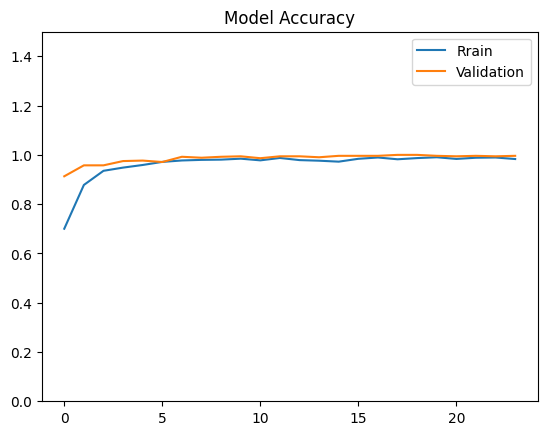

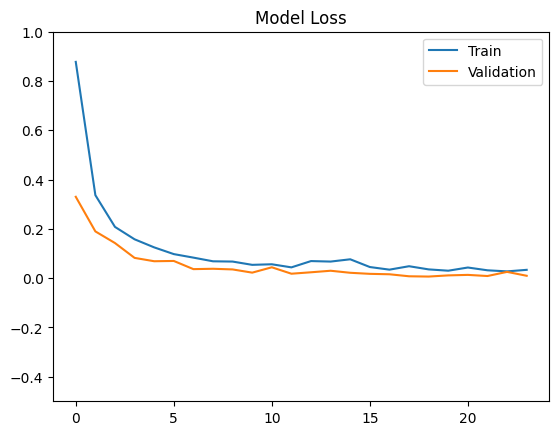

In [ ]:
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="Rrain")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.ylim([0, 1.5])
plt.show()

plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.ylim([-0.5, 1])
plt.show()

In [ ]:
import tensorflow as tf
model_extraction = tf.keras.models.load_model("/content/drive/MyDrive/TrueeTone/Training/pre_trained_cnn_model.h5")

def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, 40, 1, 1)
    result_array = model_extraction.predict(mfccs_features_scaled) ## New model implemented here
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    return result_classes[result]

test_real = "/content/drive/MyDrive/TrueeTone/Dataset/Test Audio/Test Real/linus-original_seg_4.wav"
test_fake = "/content/drive/MyDrive/TrueeTone/Dataset/Test Audio/Test Fake/linus-to-trump_seg_1.wav"
print(detect_fake(test_real))
print(detect_fake(test_fake))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
REAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
FAKE
